# API usage

In [1]:
import spatialdata
import sopa

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## Context

Sopa is built on top of the [`spatialdata` library](https://github.com/scverse/spatialdata), the core **scverse** data structure, which can be seen as an extension of `AnnData` for spatial omics.

It means that Sopa will manipulate `SpatialData` objects, that we usually denote by `sdata`.

## Create a SpatialData object

The first step is to create a `SpatialData` object from your raw data. To do so, you need to use the function from [`sopa.io`](../../api/readers) that is specific to your technology. If you don't know which raw files you need, refer to this [FAQ section](../../faq/#what-are-the-inputs-or-sopa).

> For instance, for MERSCOPE data: `sdata = sopa.io.merscope("/path/to/region_0")`.

For the sake of this tutorial, we use a synthetic dataset:

In [2]:
sdata = sopa.io.toy_dataset() # you can use `sopa.io.merscope` / `sopa.io.xenium` / ...

sdata

[INFO] (sopa.utils.data) Image of size ((4, 2048, 2048)) with 400 cells and 100 transcripts per cell


SpatialData object
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 1024, 1024), (3, 512, 512), (3, 256, 256)
│     └── 'image': DataArray[cyx] (4, 2048, 2048)
├── Points
│     ├── 'misc': DataFrame with shape: (<Delayed>, 2) (2D points)
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 5) (2D points)
└── Shapes
      └── 'cells': GeoDataFrame shape: (400, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        he_image (Images), image (Images), misc (Points), transcripts (Points), cells (Shapes)
    ▸ 'microns', with elements:
        transcripts (Points)

### Saving your data (optional)

Now that you have a `SpatialData` object, you can write it on-disk as below. 

> It creates a [`.zarr`](https://zarr.readthedocs.io/en/stable/) directory that can later be open back via `spatialdata.read_zarr`.

This step is highly recommended (although optionnal) as it can considerably speed-up the next steps.

In [3]:
sdata.write("tuto.zarr")

sdata = spatialdata.read_zarr("tuto.zarr") # we can read the data back

INFO     The Zarr backing store has been changed from None the new file path: tuto.zarr                            


Note that, when your data is saved on-disk, Sopa will automatically save on-disk any new spatial element such as the cells boundaries. To disable this behavior, you can use `sopa.settings.auto_save_on_disk = False`.

## Tissue segmentation (optional)

If desired, the tissue can be segmented (i.e., defining the contour of the tissue). This can be useful mostly for sparse tissues, as we will not run segmentation on patches that are outside of the tissue.

This tissue segmentation is either using an H&E image, or a staining image (e.g., with DAPI). For more details, refer to the documentation of [`sopa.segmentation.tissue`](../../api/segmentation/#sopa.segmentation.tissue).

> Note that, here, we have two images, but Sopa decides on which image the tissue segmentation is run. See the [FAQ](../../faq/#how-does-sopa-know-when-using-which-elements) to understand how Sopa handles this.

In [4]:
sopa.segmentation.tissue(sdata)

[INFO] (sopa.segmentation._tissue) Using image_key='he_image' and mode='saturation' as default


Now, we have a `"region_of_interest"` GeoDataFrame (see below) which contains the contour of the tissue.

In [5]:
sdata

SpatialData object, with associated Zarr store: /Users/quentinblampey/dev/sopa/docs/tutorials/tuto.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 1024, 1024), (3, 512, 512), (3, 256, 256)
│     └── 'image': DataArray[cyx] (4, 2048, 2048)
├── Points
│     ├── 'misc': DataFrame with shape: (<Delayed>, 2) (2D points)
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 5) (2D points)
└── Shapes
      ├── 'cells': GeoDataFrame shape: (400, 1) (2D shapes)
      └── 'region_of_interest': GeoDataFrame shape: (2, 1) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        he_image (Images), image (Images), misc (Points), transcripts (Points), cells (Shapes), region_of_interest (Shapes)
    ▸ 'microns', with elements:
        transcripts (Points)

On a real tissue, the `'region_of_interest'` could look like this black line:

<p align="center">
  <img src="../../assets/example_tissue_segmentation.png" alt="tissue_segmentation" width="600px"/>
</p>

### Alternative using napari

Instead of segmenting the tissue, it's possible to select interactively a region of interest (ROI) via `napari-spatialdata`, as shown in [this tutorial](https://spatialdata.scverse.org/en/latest/tutorials/notebooks/notebooks/examples/napari_rois.html).

**Important**: provide the name `region_of_interest` to your selection, and save it inside your SpatialData object with `Shift + E`.

Later on, the segmentation will only be run inside the region of interest, and not outside.

## Cell segmentation

For cell segmentation, multiple choices are available: `cellpose`, `baysor`, `comseg`, or even a combination of them (e.g., `baysor` with `cellpose` as a prior).

### Cellpose

First, we generate the bounding boxes of the patches on which Cellpose will be run. Here, the patches have a width and height of 1500 pixels and an overlap of 50 pixels. We advise bigger sizes for real datasets (see our default parameters in one of our [config files](https://github.com/gustaveroussy/sopa/tree/master/workflow/config)). On the toy dataset, this will generate **4** patches.

In [4]:
sopa.make_image_patches(sdata, patch_width=1200, patch_overlap=50)

[INFO] (sopa.patches._patches) 4 patches were added to sdata['image_patches']


The following channels are available for segmentation. Choose one or two channels used by Cellpose.

In [5]:
sopa.utils.get_channel_names(sdata)

array(['DAPI', 'CK', 'CD3', 'CD20'], dtype='<U4')

Then, we run Cellpose via the [`sopa.segmentation.cellpose`](../../api/segmentation/#sopa.segmentation.cellpose) function.

Here, we run segmentation using `"DAPI"` only, and we set the cell diameter to be about `35` pixels. Note that the diameter parameter is crucial: you can refer to [this guide](../../faq/#which-pipeline-parameters-should-i-use) to get default parameters according to your technology.
> NB: to make is faster, we can set a parallelization backend as below. See [here](../../faq/#how-to-parallelize-segmentation) for more parallelization details.

In [6]:
# optional: set the parallelization backend to use dask
sopa.settings.parallelization_backend = "dask"

In [7]:
sopa.segmentation.cellpose(sdata, channels=["DAPI"], diameter=35)

[INFO] (sopa._settings) Using dask backend


[                                        ] | 0% Completed |  3.2s

/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


[INFO] (sopa.segmentation._stainings) Found 411 total cells
Resolving conflicts: 100%|██████████| 118/118 [00:00<00:00, 3471.40it/s]
[INFO] (sopa.segmentation._stainings) Added 372 cell boundaries in sdata['cellpose_boundaries']


Now, we see that we have the `"cellpose_boundaries"` inside the `sdata` object:

In [8]:
sdata

SpatialData object, with associated Zarr store: /Users/quentinblampey/dev/sopa/docs/tutorials/tuto.zarr
├── Images
│     ├── 'he_image': DataTree[cyx] (3, 1024, 1024), (3, 512, 512), (3, 256, 256)
│     └── 'image': DataArray[cyx] (4, 2048, 2048)
├── Points
│     ├── 'misc': DataFrame with shape: (<Delayed>, 2) (2D points)
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 5) (2D points)
└── Shapes
      ├── 'cellpose_boundaries': GeoDataFrame shape: (372, 1) (2D shapes)
      ├── 'cells': GeoDataFrame shape: (400, 1) (2D shapes)
      └── 'image_patches': GeoDataFrame shape: (4, 3) (2D shapes)
with coordinate systems:
    ▸ 'global', with elements:
        he_image (Images), image (Images), misc (Points), transcripts (Points), cellpose_boundaries (Shapes), cells (Shapes), image_patches (Shapes)
    ▸ 'microns', with elements:
        transcripts (Points)

### Baysor

To use Baysor, make sure you have correctly installed it, as in our [getting started instructions](../../getting_started).

Baysor needs a config to be executed, but, by default Sopa can create one for you (if you use cellpose as a prior, see below).

You can find official config examples [here](https://github.com/kharchenkolab/Baysor/tree/master/configs). You can also reuse the Baysor parameter we have defined for each machine, as in our [Snakemake config files](https://github.com/gustaveroussy/sopa/tree/master/workflow/config).

Before actually running Baysor, we generate the bounding boxes of the patches on which Baysor will be run. Here, the patches have a width and height of 500 microns and an overlap of 50 microns (default value). We advise bigger sizes for real datasets (see our default parameters in one of our [config files](https://github.com/gustaveroussy/sopa/tree/master/workflow/config)).

In this example, we pass `prior_shapes_key="cellpose_boundaries"`, which means that Baysor will use the cellpose segmentation as a prior. You can also remove the argument if you don't want it.

In [ ]:
sopa.make_transcript_patches(
    sdata,
    patch_width=500,
    prior_shapes_key="cellpose_boundaries",
)

[########################################] | 100% Completed | 519.54 ms


[INFO] (sopa.patches._transcripts) 1 patche(s) were added to sdata['transcripts_patches']


Then, we run Baysor via the [`sopa.segmentation.baysor`](../../api/segmentation/#sopa.segmentation.baysor) function.

> NB: to make is faster, we can set a parallelization backend as below. See [here](../../faq/#how-to-parallelize-segmentation) for more parallelization details.

In [12]:
# optional: set the parallelization backend to use dask
sopa.settings.parallelization_backend = "dask"

In [11]:
sopa.segmentation.baysor(sdata, min_area=10)

[INFO] (sopa.segmentation.methods._baysor) No config provided, inferring a default Baysor config.
100%|██████████| 1/1 [00:46<00:00, 46.64s/it]
[INFO] (sopa.segmentation._transcripts) Cells whose area is less than 10 microns^2 will be removed
Reading transcript-segmentation outputs: 100%|██████████| 1/1 [00:00<00:00,  1.60it/s]
Resolving conflicts: 0it [00:00, ?it/s]
[INFO] (sopa.segmentation._transcripts) Added sdata.tables['table'], and 267 cell boundaries to sdata['baysor_boundaries']


### ComSeg

Similarly to Baysor, [ComSeg](https://comseg.readthedocs.io/en/latest/) can be used after Cellpose to improve the segmentation. The process is very similar to Baysor, except that we need the `prior_shapes_key` argument, and `write_cells_centroids=True`:

In [9]:
sopa.make_transcript_patches(
    sdata,
    patch_width=500,
    prior_shapes_key="cellpose_boundaries",
    write_cells_centroids=True,
)

[########################################] | 100% Completed | 391.20 ms


[INFO] (sopa.patches._transcripts) 1 patche(s) were added to sdata['transcripts_patches']


Then, we run Comseg via the [`sopa.segmentation.comseg`](../../api/segmentation/#sopa.segmentation.comseg) function.

In [10]:
sopa.segmentation.comseg(sdata)

[INFO] (sopa.segmentation.methods._comseg) No config provided, inferring a default ComSeg config.
  0%|          | 0/1 [00:00<?, ?it/s]OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/comseg/clustering.py:154: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=resolution)
Reading transcript-segmentation outputs: 100%|██████████| 1/1 [00:00<00:00, 16.97it/s]
Resolving conflicts: 0it [00:00, ?it/s]
[INFO] (sopa.segmentation._transcripts) Added sdata.tables['table'], and 372 cell boundaries to sdata['comseg_boundaries']


## Aggregation

The purpose of [`sopa.aggregate`](../../api/aggregation/#sopa.aggregate) is to create an `AnnData` object of features per cell. Depending on your technology, it will count the transcript/bins inside each cell, and/or average each channel intensity inside each cell boundary.

More specifically:
- For bins technologies like Visium HD data: for each cell, it will sum the transcript counts of all bins that are touching this cell.
- For transcript-based technologies like MERSCOPE/Xenium, it will count the transcripts inside each cells, and optionally average the channel intensities
- For multiplex imaging data, it will average the intensity of each channel inside each cell

You don't need to specify any argument, whatever the technology you use. See [here](../../faq/#how-does-sopa-know-when-using-which-elements) to understand how Sopa knows which elements to use for aggregation.

In [10]:
sopa.aggregate(sdata)

[INFO] (sopa.aggregation.transcripts) Aggregating transcripts over 280 cells


[########################################] | 100% Completed | 106.00 ms


[INFO] (sopa.aggregation.channels) Averaging channels intensity over 280 cells with expansion expand_radius_ratio=0


[########################################] | 100% Completed | 106.00 ms


[INFO] (sopa.aggregation.aggregation) Filtering 0 cells
/Users/quentinblampey/dev/sopa/sopa/aggregation/aggregation.py:175: ImplicitModificationWarning: Setting element `.obsm['intensities']` of view, initializing view as actual.
  self.table.obsm[SopaKeys.INTENSITIES_OBSM] = pd.DataFrame(
/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:96: UserWarning: Key `cellpose_boundaries` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Now, in the `SpatialData` object, there is a `"table"` element (which is an `AnnData` object, see below).

In [11]:
adata = sdata["table"]
adata

AnnData object with n_obs × n_vars = 280 × 6
    obs: 'region', 'slide', 'cell_id', 'area'
    uns: 'sopa_attrs', 'spatialdata_attrs'
    obsm: 'intensities', 'spatial'

What's inside adata depends on your technology:
- If you have transcripts/bins, then `adata.X` are the raw counts
- Else, `adata.X` are the channels intensities
- If you both count the transcript/bins and average the intensities, then `adata.X` are the raw counts, and `adata.obsm["intensities"]` are the channels intensities (as above)

## Annotation (optional)

Annotation within Sopa is totally optionnal. These annotations tools were optimized for annotation of large data, but feel free to perform your own.

#### Transcript-based (Tangram)

[Tangram](https://github.com/broadinstitute/Tangram) is a transcript-based annotation that uses an annotated single-cell reference. Let's suppose your reference `AnnData` object is stored in a file called `adata_reference.h5ad` (preferably, keep raw counts), and the cell type is in `adata.obs["cell_type"]`. Then, you can annotate your spatial data as follows:

In [ ]:
import anndata

adata_reference = anndata.read_h5ad("adata_reference.h5ad")

sopa.utils.tangram_annotate(sdata, adata_reference, "cell_type")

#### Staining-based
For now, our fluorescence-based annotation is very simple. We provide a dictionary where a channel is associated with a population. Then, each cell is associated with the cell type whose corresponding channel is the brightest (according to a certain Z-score). In this tutorial example, we can annotate Tumoral cells, T cells, and B cells:

In [12]:
marker_cell_dict = {
    "CK": "Tumoral cell",
    "CD20": "B cell",
    "CD3": "T cell"
}

sopa.utils.higher_z_score(sdata.tables["table"], marker_cell_dict)

[INFO] (sopa.utils.annotation) Annotation counts: cell_type
Tumoral cell    97
T cell          93
B cell          90
Name: count, dtype: int64


## Visualization

Many visualization tools can be used. Here, we show three of them, with different capabilities.

### With the Xenium Explorer

The Xenium Explorer is a software developed by 10X Genomics for visualizing spatial data, and it can be downloaded freely [here](https://www.10xgenomics.com/support/software/xenium-explorer/latest). This is the most user-friendly visualizer of the three, but it may not show all the spatial element from your `SpatialData` object (it only shows images, transcripts, and cell boundaries).

Sopa allows the conversion to the Xenium Explorer, whatever the type of spatial data you worked on.

The command below creates some files under a new `tuto.explorer` directory:

In [13]:
sopa.io.explorer.write("tuto.explorer", sdata)

[INFO] (sopa.io.explorer.table) Writing table with 6 columns
[INFO] (sopa.io.explorer.table) Writing 3 cell categories: region, slide, cell_type
[INFO] (sopa.io.explorer.shapes) Writing 280 cell polygons
[INFO] (sopa.io.explorer.points) Writing 40000 transcripts
[INFO] (sopa.io.explorer.points)    > Level 0: 40000 transcripts
[INFO] (sopa.io.explorer.points)    > Level 1: 10000 transcripts
[INFO] (sopa.io.explorer.images) Writing multiscale image with procedure=semi-lazy (load in memory when possible)
[INFO] (sopa.io.explorer.images)    (Loading image of shape (4, 2048, 2048)) in memory
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 2048, 2048)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 1024, 1024)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 512, 512)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 256, 256)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 128, 128)
[INFO] (sopa.io.explorer.images)    > Image of shape (4, 64, 64)
[I

If you have downloaded the Xenium Explorer, you can now open the results in the explorer: simply double-click on the `tuto.explorer/experiment.xenium` file. For more advanced usage of the Xenium Explorer, refer to [this tutorial](../xenium_explorer/explorer).

### With spatialdata-plot
[`spatialdata-plot`](https://github.com/scverse/spatialdata-plot) library is a static plotting library for `SpatialData` objects. This solution is very convenient when working in Jupyter Notebooks.

You can install it via `pip install spatialdata-plot`

In [14]:
import spatialdata_plot

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      
INFO     Rasterizing image for faster rendering.                                                                   


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.9530949634755863].
/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/anndata/_core/anndata.py:430: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/Users/quentinblampey/dev/_external/spatialdata/src/spatialdata/_core/_elements.py:106: UserWarning: Key `misc` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)
/Users/quentinblampey/mambaforge/envs/sopa/lib/python3.10/site-packages/spatialdata_plot/pl/render.py:494: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _

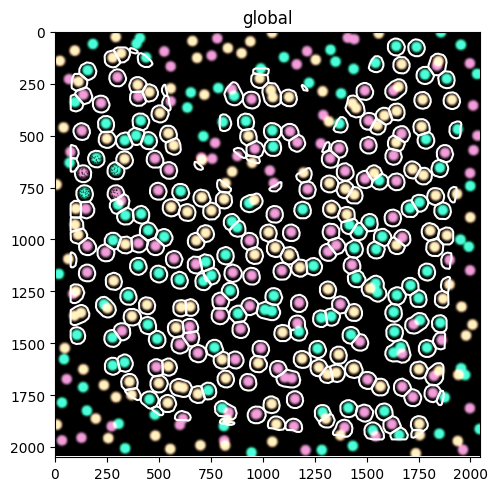

In [15]:
sdata\
    .pl.render_images("image")\
    .pl.render_points(size=0.01, color="#000000", alpha=1)\
    .pl.render_shapes("cellpose_boundaries", outline_alpha=1, fill_alpha=0, outline_color="#fff")\
    .pl.show("global")

### With napari-spatialdata

[`napari-spatialdata`](https://github.com/scverse/napari-spatialdata) is a plugin for [Napari](https://napari.org/stable/) developed to visualize your SpatialData objects. This visualizer is very flexible, as you can display any spatial element, and you can directly save annotations from Napari in your SpatialData object.

You can install it via `pip install 'napari-spatialdata[all]'`

In [ ]:
from napari_spatialdata import Interactive

Interactive(sdata)

## Pipeline report
You can optionally create an HTML report of the pipeline run (in the example below, we save it under `report.html`). It contains some quality controls for your data.

In [20]:
sopa.io.write_report("report.html", sdata)

[INFO] (sopa.io.report.generate) Writing general_section
[INFO] (sopa.io.report.generate) Writing cell_section
[INFO] (sopa.io.report.generate) Writing channel_section
[INFO] (sopa.io.report.generate) Writing transcripts_section
[INFO] (sopa.io.report.generate) Writing representation_section
[INFO] (sopa.io.report.generate) Computing UMAP on 268 cells
[INFO] (sopa.io.report.generate) Writing report to report.html


## Further analyses

If not done yet, you can save your SpatialData object, as below. It will create a `.zarr` directory.

In [ ]:
sdata.write("tuto.zarr")

This way, you'll be able to open it later for further analysis, using `spatialdata.read_zarr("tuto.zarr")`.

Now, here is a list of ressources you may consider to go further:
- [This tutorial](../spatial) on spatial statistic and geometric analysis.
- Use [Squidpy](https://squidpy.readthedocs.io/en/latest/index.html) which operates on both the `SpatialData` object or the `AnnData` object, or use other tools of the `scverse` ecosystem such as [`Scanpy`](https://scanpy.readthedocs.io/en/stable/index.html).
- You can also try the CLI or the Snakemake pipeline of Sopa.